In [48]:
import numpy as np
import gym
import random
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.models import load_model

env = gym.make('LunarLander-v2')

In [61]:
def Q_model(state_dim, n_action, lr=0.001):
    model = Sequential()

    model.add(Dense(64, input_dim=state_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_action, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=lr))
    return model


        
class DQL_agent():
    def __init__(self, dS, nA, max_episodes, batch_size, gamma, update_freq, epsilon, epsilon_decay, lr=0.001, epochs=1):
        self.dS = dS
        self.nA = nA
        self.max_episodes = max_episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epochs = epochs
        
        self.model = Q_model(dS, nA, lr)
        self.target_model = Q_model(dS, nA, lr)  
        self.memory = deque(maxlen=self.batch_size * 100)
        
        self.copy_weight()
        
    def epsilon_greedy(self, s, epsilon):
        if np.random.random() < epsilon:
            return np.random.randint(0, self.nA)
        else:
            return np.argmax(self.model.predict(np.expand_dims(s, axis=0))[0])
        
    def update(self):
        batch = np.array(random.sample(self.memory, self.batch_size))
        s, next_s = np.vstack(batch[:,0]), np.vstack(batch[:,3])
        a, r, done = np.array(batch[:,1], dtype='int'), np.array(batch[:,2], dtype='float'), np.array(batch[:,4], dtype='bool')
        Q = self.model.predict(s) #current prediction of Q values (n_sample * n_action)
        new_Q = r #target prediction of Q values
        not_done_idx = np.where(~done)[0]
        new_Q[not_done_idx] += self.gamma * np.max(self.target_model.predict(next_s[not_done_idx, :]), axis=1)
        Q[range(Q.shape[0]), a] = new_Q #update Q of a to new_Q
        self.model.fit(x=s, y=Q, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        
    def copy_weight(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def Q_learning(self, env, warm_start=False):

        i = 0
        if not warm_start:
            self.episode_rewards = []
            self.curr_epsilon = self.epsilon

        for n in range(self.max_episodes):
            s = env.reset()
            
            done = False
            episode_reward = 0
            while not done:
                a = self.epsilon_greedy(s, self.curr_epsilon)
                next_s, r, done, info = env.step(a)
                i += 1
                self.memory.append([s, int(a), r, next_s, done])
                if i>=self.batch_size and i%self.batch_size==0:
                    self.update()
                if i%(self.update_freq*self.batch_size)==0:
                    self.copy_weight()
                    
                s = next_s
                episode_reward += r
                
            self.episode_rewards.append(episode_reward)
            self.curr_epsilon *= self.epsilon_decay
            if n%100 == 0:
                print(n, np.mean(self.episode_rewards[-100:]))
                
    def save_model(self, f):
        self.model.save(f)
        
    def load_model(self, f):
        self.model = load_model(f)
        self.copy_weight()

predict_sprime = self.model.predict(np.vstack(minibatch[:, 3]))
            predict_sprime_target = self.target_model.predict(np.vstack(minibatch[:, 3]))
            
            # Non-terminal update rule
            y[not_done_indices] += np.multiply(self.gamma, \
                        predict_sprime_target[not_done_indices, \
                        np.argmax(predict_sprime[not_done_indices, :][0], axis=1)][0])

In [62]:
env = gym.make('LunarLander-v2')
dS = env.observation_space.shape[0]
nA = env.action_space.n
max_episodes = 1000
batch_size = 32
gamma = 1
update_freq = 10
epsilon = 0.2
epsilon_decay = 0.999
agent = DQL_agent(dS, nA, max_episodes, batch_size, gamma, update_freq, epsilon, epsilon_decay)

In [63]:
agent.load_model("weights/first_attempt1000.h5")
agent.Q_learning(env)

0 -49.24341749033698
100 -3.2517492959698266
200 -12.482540109311444
300 -18.0606337961607
400 -18.732879066227365


KeyboardInterrupt: 

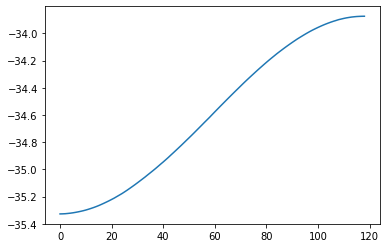

In [58]:
from scipy.ndimage.filters import gaussian_filter1d

y = gaussian_filter1d(agent.episode_rewards, sigma=100)
plt.plot(y)